# План -- залог успеха

1. Предобрабатываем и анализируем тексты
    * Строим облако слов в т.ч.
2. Пробуем разные подходы к токенизации
3. Исключаем и не исключаем стоп-слова
4. Да и нет лемматизации//стеммингу
5. Простые векторизации: bag-of-words, CountVectorizer, TfIdfVectorizer
    * Уни-, би- и другие граммы
6. Модели: логрег, SVM
7. Катбуст с текстовыми фичами
8. Аналитика результатов
9. Предложения ребят(ам), как можно улучшить прогноз
    * языковые фичи;
    * аугментации текстов;
    * ...

На любые вопросы по этой домашке постарается ответить Савелий (TG: @Savely_Prokhorov). Не стесняйтесь спрашивать, ему будет приятно помочь.

И помните:

> Не существует глупых вопросов!

Вы можете что-то не знать из того, что нужно для полного выполнения этой домашки -- и это не стыдно. Давайте учиться вместе!

В этом ноутбуке мы выделили **жирным** некоторые рекомендации по тому, что можно улучшить в бейзлайне, чтобы попытаться выбить скор получше.  

Модели давайте сравнивать по $R^2$ ([Вики про коэффициент детерминации](https://en.wikipedia.org/wiki/Coefficient_of_determination))



> **Сохраняйте промежуточные результаты: некоторые алгоритмы отрабатывают довольно долго, обидно будет потерять результаты вычислений; к тому же сохранённые модели (вместе с пайплайнами предобработки, если они отличаются) будет легче состекать**



> А ещё вам могут быть полезны [пайплайны из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Если хорошо приспособите -- будет довольно удобно




In [ ]:
# !pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 76.1 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=157d79214cc9b0d8f4033b35a25348a50d45dc7be3e4abcee11106ac425b8eff
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

from gensim.models import Word2Vec

from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 8]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Борис\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Борис\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Борис\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Борис\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Загрузка данных

In [2]:
df_train = pd.read_csv('vacancies_train.csv')

df_train

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0
...,...,...,...,...,...,...,...
16624,Полицейский специального полка полиции,Нет опыта,Полный день,Полная занятость,Обязанности: обеспечение общественного поряд...,"['Грамотная речь', 'Обучение и развитие', 'Упр...",67500.0
16625,Врач стоматолог-ортопед (г. Новосибирск),Нет опыта,Полный день,Полная занятость,Обязанности: Оказывает квалифицированную меди...,['Медицинская документация'],50000.0
16626,Фармацевт,От 1 года до 3 лет,Полный день,Полная занятость,Условия: официальное оформление по ТК РФ; гра...,"['Пользователь ПК', 'Работа в команде', 'Грамо...",50000.0
16627,Геодезист (автодороги),От 1 года до 3 лет,Вахтовый метод,Полная занятость,Обязанности: своевременное и качественное вып...,[],75000.0


In [3]:
df_test = pd.read_csv('vacancies_test.csv', index_col=0) # честный тест -- для него у вас не будет ответов
# а вот на валидацию можете себе, сколько нужно, откусить от трейна
df_test

,name,experience,schedule,employment,description,key_skills
id,,,,,,
0,Главный бухгалтер,Более 6 лет,Полный день,Полная занятость,Обязанности:Осуществление организации бухгалте...,"['1С: Предприятие 8', '1C: Предприятие', 'Рабо..."
1,Ассистент врача-стоматолога,От 1 года до 3 лет,Сменный график,Полная занятость,"Обязанности: Ассистировать врачу стоматологу,...","['Пользователь ПК', 'Работа в команде', 'Умени..."
2,Менеджер по продажам,От 1 года до 3 лет,Полный день,Полная занятость,Если ты: хочешь построить карьеру в банковс...,[]
3,Менеджер,От 1 года до 3 лет,Полный день,Полная занятость,Динамично развивающаяся на протяжении 17 лет...,"['Оценка потребностей клиентов', 'оформление д..."
4,Администратор хостела,Нет опыта,Сменный график,Полная занятость,ВОЗМОЖНА РАБОТА С ПРОЖИВАНИЕМ Обязанности: Пр...,[]
...,...,...,...,...,...,...
5538,Специалист по дистанционному контролю качества...,От 1 года до 3 лет,Удаленная работа,Полная занятость,Обязанности: проводить визуальный контроль а...,"['Удаленная работа', 'Грамотная речь', 'Пользо..."
5539,Продавец-консультант,Нет опыта,Полный день,Полная занятость,Компания ONE SMOKE приглашает к сотрудничеству...,"['Пользователь ПК', 'Розничная торговля', 'Раб..."
5540,Фельдшер скорой медицинской помощи,От 3 до 6 лет,Сменный график,Полная занятость,Обязанности: Осуществляет оказание скорой мед...,[]


# Простейший EDA

Для начала посмотрим на распределение таргета в трейне. Видим выбросы совсем низкой зарплаты. **Посмотрите на описание вакансий с выбросами** -- это может помочь объяснить их.

<Axes: xlabel='salary', ylabel='Count'>

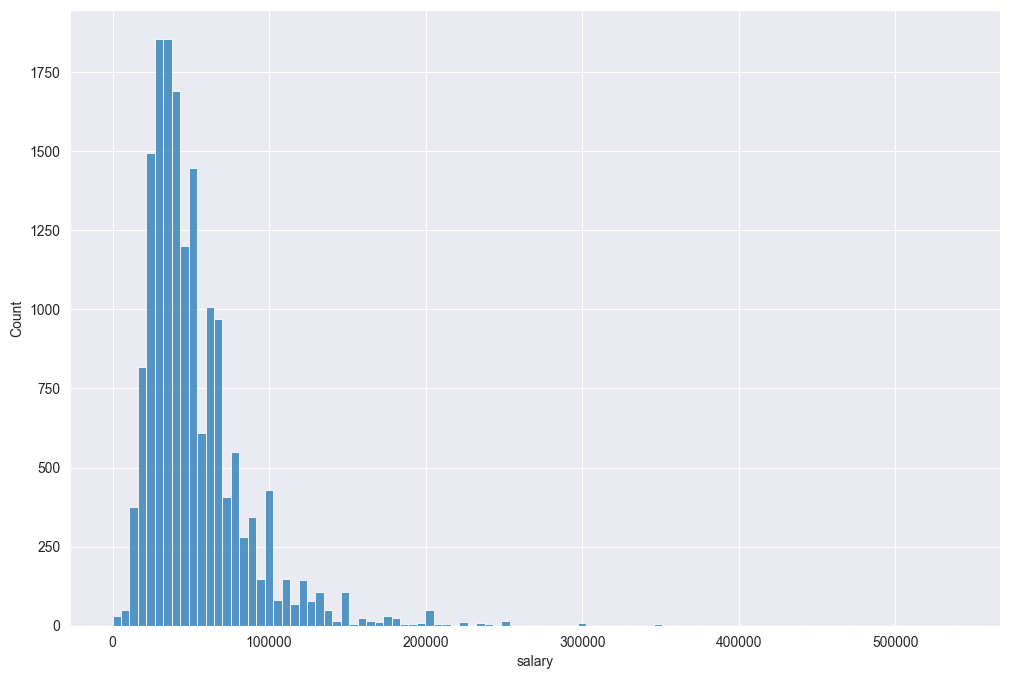

In [4]:
sns.histplot(df_train.salary, bins=100)

In [5]:
pd.set_option('display.max_colwidth', None)
threshold = df_train.salary.quantile(0.001)
df_train[df_train.salary < threshold][['name', 'description', 'salary']].sort_values(by='salary')
# там где зп 30-60 это скорее всего значение в тысячах
# а большее, уже зп в час/смену

,name,description,salary
2641,Продавец консультант/старший(ТЦ Эльгрин),"Должностные обязанности: - консультирование клиентов по ассортименту (обувь, сумки, носочно-чулочная продукция, средства по уходу за обувью); - предпродажная подготовка товара; - поддержание чистоты и порядка в торговом зале. Требования: - клиентоориентированность, желание зарабатывать, доброжелательность; - знание технологии продаж, кассовой дисциплины, основ мерчендайзинга. Условия: - работа в крупной федеральной розничной сети; - официальное трудоустройство, полный социальный пакет; -100% «белая» зарплата; - скидки на продукцию; - возможность учиться и развиваться вместе с компанией. Приглашаем вас на собеседование в наш магазин ""Белвест"" по адресу ул. 10 лет Октября,53(ТЦ Эльгрин)",30.0
16235,Комплектовщик (Тарасовка),"Сервис доставки продуктов Ленточка приглашает в свою команду на должность Комплектовщик заказов. Мы молодой быстро развивающийся старт-ап внутри сети магазинов Лента. Строим новый для ритейла сервис доставки продуктов от 30 минут (и действительно уже так быстро доставляем) и динамично растем. У нас много интересных задач и возможностей для развития и роста. Скучно точно не будет!Обязанности собирать заказы в торговом зале магазина по мобильному приложению созваниваться с клиентами по наполнению корзины передавать собранный заказ курьеру для доставки в свободное от заказов время пополнять полки товаром Требования активность и быстрота грамотная речь Опыт работы на позициях комплектовщик, упаковщик, грузчик, работник торгового зала, мерчендайзер, разнорабочий, подсобный рабочий, работник склада, оператор склада, кассир, будет огромным плюсом!НО это необязательно, мы берем и БЕЗ ОПЫТА работы!Условия официальное оформление с 1-ого рабочего дня гибкий график работы, возможность подработки возможность работать рядом с домом (в одном магазине) современные гаджеты для работы с оплатой мобильной связи оформление личной медицинской книжки за счет Компании вознаграждение в связи с трудоустройством, +15 % к часовой ставке за первый месяц работы стабильная выплата заработной платы 2 раза в месяц ежемесячное премирование по результатам работы система надбавок (выслуга лет, особые условия труда) дополнительная скидка для сотрудников в магазинах «ЛЕНТА» бесплатная униформа внутрикорпоративное обучение возможность участия в профессиональных и корпоративных конкурсах подарки для сотрудников и для детей на праздники бесплатная медицинская страховка Звони и стань частью команды (телефон многоканальный, звонок по России бесплатный)",44.0
13491,Инженер-экономист,"Обязанности Работа с ресурсоснабжающими организациями и отчетами. • Ежемесячный анализ счетов-фактур от Ресурсоснабжающих организаций • Учет и анализ доходов и расходов по коммунальным услугам в разрезе МКД; • Осуществление сверки с ресурсоснабжающими организациями в части корректности предъявляемых объемов коммунальных услуг; • Подготовка статистических отчетов по форме 22-ЖКХ; • Расчет, анализ, подготовка документов для судебных процессов • Ответы на письма, запросы жителей, строй надзор, прокуратура. • Организация работы по формированию годовых отчетов перед собственниками МКД • Отчетность по выпадающим доходам Требования: Знание:- действующего гражданского законодательства, регулирующего правоотношения в области заключения и расторжения договоров ресурсоснабжения;- нормативных и законодательных актов;- нормативно – технических документов, касающихся теплоснабжения, водоснабжения, водоотведения;- расчетов количества отпущенного коммунального ресурса, объемов потребления коммунального ресурса по приборам учета тепловой энергии; - самостоятельность; -стрессоустойчивость; - коммуникабельность; - умение работать в команде; - доброжелательность; - умение отстоять свою позицию при общении с оппонентами. Условия: Полный рабочий день;",45.0
163,Ведущий специалист/Руководитель тендерного отдела,"Компания-поставщик медицинских расходных материалов ищет руководителя тендерного отдела в офис в г. Бердске. Г

В логарифмированной шкале распределение больше похоже на нормальное (ежели отбросить левый хвост с выбросом). **Подумайте, возможно стоит как-нибудь обработать выбросы или их удалить**

<Axes: xlabel='salary', ylabel='Count'>

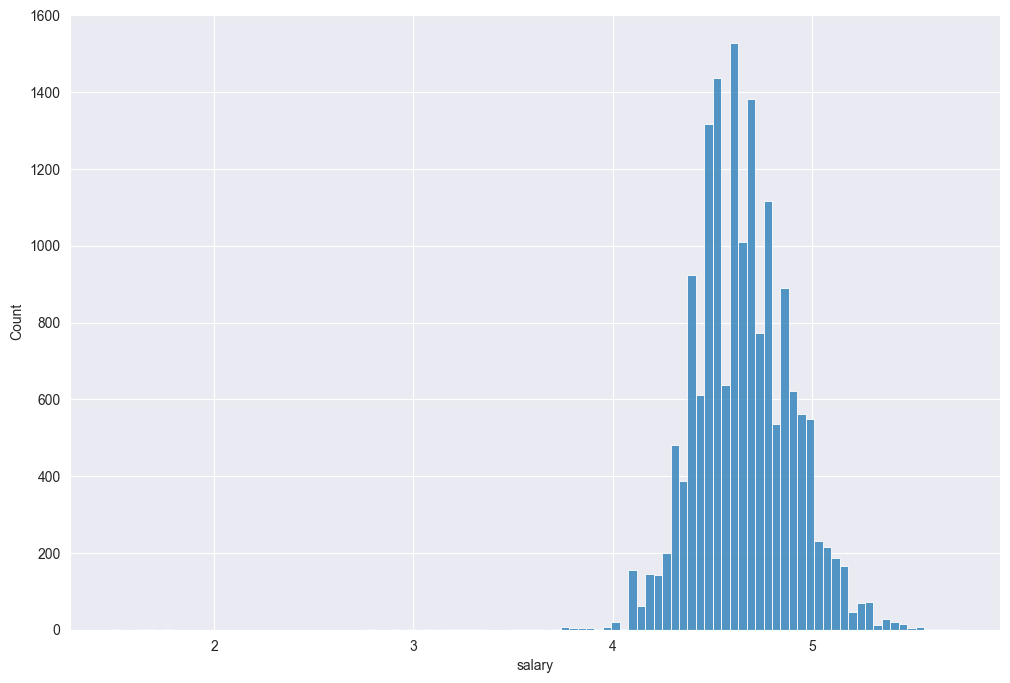

In [6]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

In [7]:
df_train.name.value_counts()

name
Менеджер по продажам                                          208
Продавец-консультант                                          180
Менеджер по работе с клиентами                                111
Кладовщик                                                     111
Бухгалтер                                                     108
                                                             ... 
Упаковщица/Упаковщик                                            1
Помощник официанта,ранер                                        1
Менеджер по продаже оборудования для общепита и торговли        1
Электросварщик на полуавтомат (морской регистр, НАКС НГДО)      1
Специалист-эксперт отдела правового обеспечения                 1
Name: count, Length: 9915, dtype: int64

In [8]:
# your code here
df_train['salary'] = df_train.apply(lambda x: x['salary'] * 1000 if x['salary'] < 100 else x['salary'], axis=1)
mask = (df_train.salary < threshold) & (df_train['description'].str.lower().str.contains('за смену|за день|смена|ежедневно|выход|руб./ день|смены'))
df_train.loc[mask, 'salary'] = df_train.loc[mask].apply(lambda x: x['salary'] * 22, axis=1)
# Была идея с обработкой вакансий с зп по часам/дням, возможно стоило бы такой признак сделать и добавить его как новый столбец, но я не сделал)))

In [9]:
threshold = df_train.salary.quantile(0.005)
df_train[df_train.salary < threshold][['name', 'description', 'salary']].sort_values(by='salary')
# там где зп 30-60 это скорее всего значение в тысячах
# а большее, уже зп в час/смену

,name,description,salary
13075,Официант,"Кафе грузинской кухни «Кинза» приглашает в свою команду официантов. Если ты позитивный, честный, любишь и умеешь работать в команде, мы ждем тебя! Обязанности: • подготовка кафе к встрече гостей; • знание меню (основное и сезонное) и барной карты; • работа с кассой R-Keeper. ​Требования: • опыт работы в общепите от 1 года; • знание основных шагов сервиса в ресторане; • навыки работы в R-Keeper; • хорошие коммуникативные навыки; • стрессоустойчивость, умение владеть собой и улаживать конфликты в стадии их зарождения; • вежливость, приветливость, знание этикета ​Условия: • сменный график (оговаривается индивидуально); • предоставляется питание и форма; • стабильная и своевременная оплата; • работа в центре города; • оформление по ТК РФ",1500.0
11311,Подработка с ежедневной выплатой,"Требуются сотрудники на подработку в разные районы города: (подработка по требованию) Должностные обязанности сотрудников (на выбор): Разгрузка, выгрузка(торговый зал/производство(от 147руб/час) Выкладка товара;(от 138 руб/час) Работа на кассе.(от 145 руб/час) Требования к соискателю: Ответственность; Обязательно опыт работы в данной сфере и в смежных областях на должности разнорабочего/кладовщика/грузчика/мерчендайзера/кассира; Наличие мед. книжки приветствуется. Условия работы/график работы График работы СВОБОДНЫЙ (вы сами выбираете в какой день и куда пойдете работать); Работа в дневное время; Рабочий день от 8-ми часов до 11 часов; Оплата почасовая безналичным расчетом, в течение последующего дня или еженедельная . ЗВОНИТЕ или ПИШИТЕ в WhatsApp!",1600.0
621,Повар-универсал,"Обязанности Повар универсал. Заготовка полуфабрикатов для пиццы и холодного цеха. Оформление ветрины. Требования: Коммуникабельность, Умение работать в команде, чистоплотность, ответственность. Приветствуются навыки работы с тестом и кондитерские . Условия: Повар - универсал пят, суб, воск., праздничные дни. С 11:00 до 23:00 1800",1800.0
3990,Охранник,"Обязанности: охрана территории коттеджного поселка Требования: Удостоверение частного охранника, 4 разряд (можно 5,6) Условия: вахтовый метод работы заработная плата выплачивается вовремя",2000.0
275,Сотрудник на пересчет товара,"Для проведения инвентаризации требуется Сотрудник по пересчету товара Рассматриваем кандидатов БЕЗ ОПЫТА! МЫ ПРЕДЛАГАЕМ: Оплата: 1200 рублей после смены; Смена: 17.08 ночь; Бесплатное обучение (инструктаж перед сменой); Быстрое оформление (за 24 часа); Оформление согласно законодательству РФ; Возможность влиять на свой доход. ЧТО ДЕЛАТЬ: Осуществлять пересчет и сканирование товара при помощи сканера (ТСД); Приводить торговый зал в первоначальный вид после инвентаризации. КАКИМ БЫТЬ: Честным; Выносливым; Пунктуальным. ✅ Приветствуется опыт работы в должностях: продавец, администратор, официант, кассир, продавец-консультант, работник торгового зала, оператор, комплектовщик, маркировщик, грузчик, упаковщик, сортировщик, фасовщик, разнорабочий, работник склада. ✅ За более подробной информацией и записи на собеседование (с 10.00 до 18.00 в будни) звони по телефону, указанному в объявлении либо отправь СМС или сообщение в мессенджерах WhatsApp/Viber c указанием ФИО, контактного номера телефона и города, в котором Вы проживаете, мы Вам перезвоним! ЗВОНИ!",2100.0
...,...,...,...
8709,Повар,"Обязанности: непосредственно осуществляет приготовление блюд, в том числе: мойку и бланшировку продуктов, смешивание продуктов, жарку, запекание, варку на пару, приготовление соусов, супов, бульонов. Требования: Опыт работы",12000.0
9341,Удаленный менеджер по подбору персонала,"Нам нужен эффективный удаленный менеджер по подбору персонала для привлечения квалифицированных специалистов в области оптовых поставок строительных материалов. Конечным результатом Вашей работы будет выполнение плана найма и вывод на стажировку кандидатов, соответствующих требованиям компании. Обязанности: Ближайшая задача: Найти менеджера по продажам нерудных материалов, менеджера по продаже ЖБИ(железобетонны

In [10]:
mask = (df_train.salary < threshold) & (df_train['description'].str.lower().str.contains('за смену|за день|смена|ежедневно|выход|руб./ день|смены'))
df_train.loc[mask, 'salary'] = df_train.loc[mask].apply(lambda x: x['salary'] * 22, axis=1)

In [11]:
threshold = df_train.salary.quantile(0.001)
df_train[df_train.salary < threshold][['name', 'description', 'salary']].sort_values(by='salary')
# там где зп 30-60 это скорее всего значение в тысячах
# а большее, уже зп в час/смену

,name,description,salary
13075,Официант,"Кафе грузинской кухни «Кинза» приглашает в свою команду официантов. Если ты позитивный, честный, любишь и умеешь работать в команде, мы ждем тебя! Обязанности: • подготовка кафе к встрече гостей; • знание меню (основное и сезонное) и барной карты; • работа с кассой R-Keeper. ​Требования: • опыт работы в общепите от 1 года; • знание основных шагов сервиса в ресторане; • навыки работы в R-Keeper; • хорошие коммуникативные навыки; • стрессоустойчивость, умение владеть собой и улаживать конфликты в стадии их зарождения; • вежливость, приветливость, знание этикета ​Условия: • сменный график (оговаривается индивидуально); • предоставляется питание и форма; • стабильная и своевременная оплата; • работа в центре города; • оформление по ТК РФ",1500.0
11311,Подработка с ежедневной выплатой,"Требуются сотрудники на подработку в разные районы города: (подработка по требованию) Должностные обязанности сотрудников (на выбор): Разгрузка, выгрузка(торговый зал/производство(от 147руб/час) Выкладка товара;(от 138 руб/час) Работа на кассе.(от 145 руб/час) Требования к соискателю: Ответственность; Обязательно опыт работы в данной сфере и в смежных областях на должности разнорабочего/кладовщика/грузчика/мерчендайзера/кассира; Наличие мед. книжки приветствуется. Условия работы/график работы График работы СВОБОДНЫЙ (вы сами выбираете в какой день и куда пойдете работать); Работа в дневное время; Рабочий день от 8-ми часов до 11 часов; Оплата почасовая безналичным расчетом, в течение последующего дня или еженедельная . ЗВОНИТЕ или ПИШИТЕ в WhatsApp!",1600.0
621,Повар-универсал,"Обязанности Повар универсал. Заготовка полуфабрикатов для пиццы и холодного цеха. Оформление ветрины. Требования: Коммуникабельность, Умение работать в команде, чистоплотность, ответственность. Приветствуются навыки работы с тестом и кондитерские . Условия: Повар - универсал пят, суб, воск., праздничные дни. С 11:00 до 23:00 1800",1800.0
3990,Охранник,"Обязанности: охрана территории коттеджного поселка Требования: Удостоверение частного охранника, 4 разряд (можно 5,6) Условия: вахтовый метод работы заработная плата выплачивается вовремя",2000.0
9171,Мерчендайзер (Ашан),"Приглашаем стационарных мерчендайзеров на подработку/совмещение по сети Ашан. Торговая точка: Липецк, Ашан, ул. им. героя России Эдуарда Белана 26. Условия: Продукция - игристые вина, шампанское. Посещение 3 раза в неделю с чередованием через день, по 1 часу в точке. Оплата 2 200 руб. в месяц. Требования: Опыт работы мерчендайзером/торговым представителем/ртз; Обязательно наличие действующей санитарной книжки, Смартфон или планшет на базе Андроид (ios не подходит). Обязанности: Выкладка продукции согласно планограмме; Контроль наличия и актуальности ценников; Снятие остатков, контроль сроков годности; Качественный фотоотчет о проделанной работе.",2200.0
3460,Монолитчик,Обязанности: Монолит Плита перекрытия Плита основания Колонны Стены Требования: Опыт работ не менее трех лет Трудоспособность Условия: От 3000 до 3500 руб за 1м3 в зависимости от вида монолита График свободный,3250.0
2639,"Мерчендайзер, Зима (напитки)","Международная компания «АНКОР», лидер кадрового рынка, открывает вакансию Мерчендайзера для работы с крупнейшей FMCG компанией в категории ""напитки"" (сок, минеральная вода, газированные напитки). Требования: Желателен опыт работы с продуктами питания в качестве мерчендайзера, продавца, работника торгового зала. Рассматриваем и обучаем кандидатов без опыта работы; Обязательно наличие действующей медицинской книжки (для продовольственных товаров); Обязательно наличие мобильного устройства на операционной системе Android (версия выше 4.4), либо IOS (версия от 5.0); Личные качества: ответственность, коммуникабельность, результативность, активная жизненная позиция. Должностные обязанности: Обеспечение выкладки товара на вверенной территории согласно стандартам компании и планограмме сети; Отслеживание сроков годности продукции, наличия и корректности ценников,

In [12]:
threshold = df_train.salary.quantile(0.001)
df_train = df_train[(df_train['salary'] >= threshold)]
df_train

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ тент, ГАЗЕЛЬ цельнометаллическая, ГАЗ фургон) Обязанности: развоз товара по точкам в черте г.Владимира и области по графику, доставка товара в Москву, Иваново, Рязань, экспедирование, приемка-передача товара в точках, разгрузка товара в точках, материальная ответственность за транспортное средство, груз, товаросопроводительные документы, содержание подотчетного транспортного средства в технически исправном рабочем состоянии, мелкий текущий ремонт и техобслуживание Требования: наличие водительского удостоверения категории В и/или С, спокойствие, выносливость, достаточная подготовка, вежливость, опыт текущего ремонта и техобслуживания отечественных транспортных средств Условия: выплата заработка 2 раза в месяц отпуск два раза в год (осень-весна) по 14 календарных дней официальное трудоустройство и соцпакет",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,"Обязанности: Списывание материалов в производство Прием ТМЦ, разгрузка товара Оприходование материалов и готовой продукции на склад Размещение материалов на складе Ведение документооборота Контроль складских остатков Составление заявок на пополнения складских остатков Ведение номенклатуры в базе 1С Обеспечение сохранности ТМЦ Поддержание порядка на складе. Требования: Знание программы 1с Внимательность, аккуратность Умение работать в команде Знание номенклатуры металлопроката будет преимуществом Условия: отличный коллектив, людей, которые ответственно относятся к своей работе, отвечают каждый за свою работу и результат, у нас точно не получится просто ""отбывать номер"", мы платим зарплату по верхней планке за работу есть опытный кладовщик, который всё покажет, инструкции по выполнению всех операций в 1С быстро растущая торгово-производственная компания, лидер рынка производства дизайнерского света и инсталляций производим светильники высокого качества по индивидуальным заказам. испытательный срок 1 мес оформление по ТК РФ график 5/2 с 9.00 до 18.00, у нас даже время обеда оплачивается все необходимые бытовые условия - раздевалка, место для обедов, холодильник, микроволновые печи, спецодежда и СИЗ Пишите в Whats App или звоните!","['знание пк', 'работа в 1С', 'Работа в команде', 'Складской Учет', 'Складской документооборот', '1С: Производство', 'Организация движения и учета документов', 'Internet', 'Работа с ТМЦ', 'Контроль отгрузок', 'Ориентация на результат']",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В. Уса)",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магнит"" требуется продавец магазина в связи с расширением. Обязанности: - обслуживание покупателей на кассе;- консультирование покупателей при выборе товара;- участие в выкладке товаров, актуализации ценников;- участие в инвентаризациях Требования: - Исполнительность,- Умение работать в команде,- Высокая работоспособность,- Ответственность.- Приветствуется стремление к обучению, развитию и освоению новых технологий. Условия: - График 2/2, 12 часовой рабочий день,- Официальная заработная плата,- Работа рядом с домом,- Корпоративные пенсионные программы,- Корпоративное обучение,- Конкурсы профессионального мастерства Благодарим Вас за интерес, проявленный к нашей Компании.Стандартный срок рассмотрения резюме -14 дней.Отсутствие ответа в течение двух недель означает, что, к сожалению, на сегодня у нас нет подходящих вакансий. При этом Ваше резюме будет сохранено в нашей базе данных и если подходящая вакансия появится в последующем, мы предложим ее Вам для рассмотрения.Если Ваш опыт работы и пожелания соответствуют требованиям и возможностям компании - мы свяжемся с Вами по указанным контактам в течении двух недель.",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,"Крупная федеральная сеть магазинов мужско

По графику ниже, видим, что вакансий для опытных соискателей сравнительно немного. **Попробуйте визуализировать совместное распределение опыта работы и предлагаемой зп**

In [103]:
df_train.shape

(16612, 9)

<Axes: xlabel='experience', ylabel='Count'>

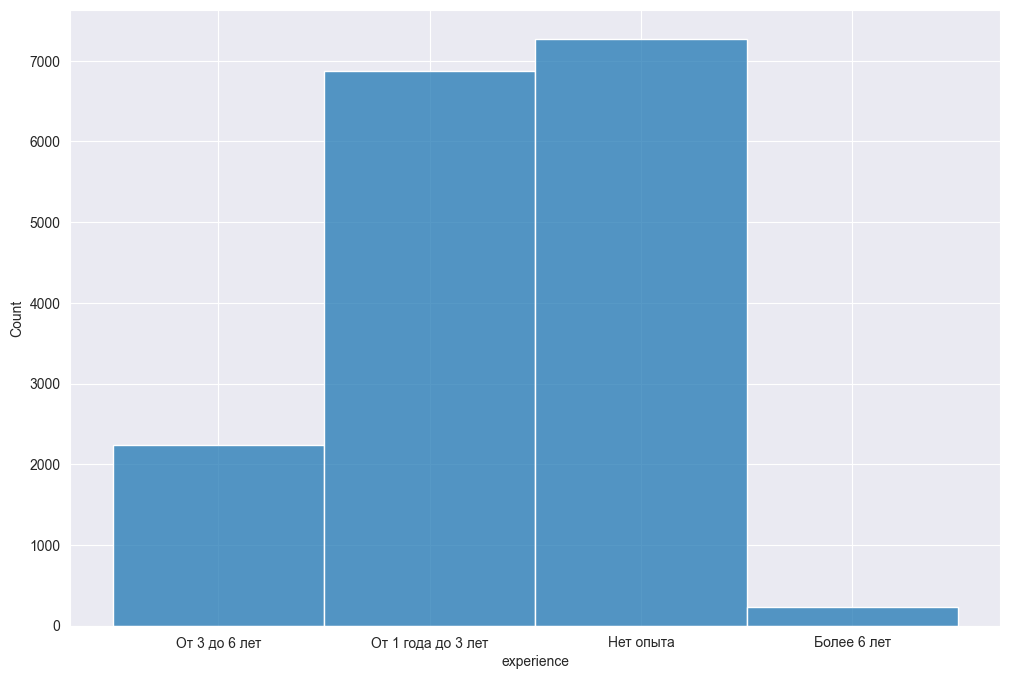

In [13]:
sns.histplot(df_train.experience)

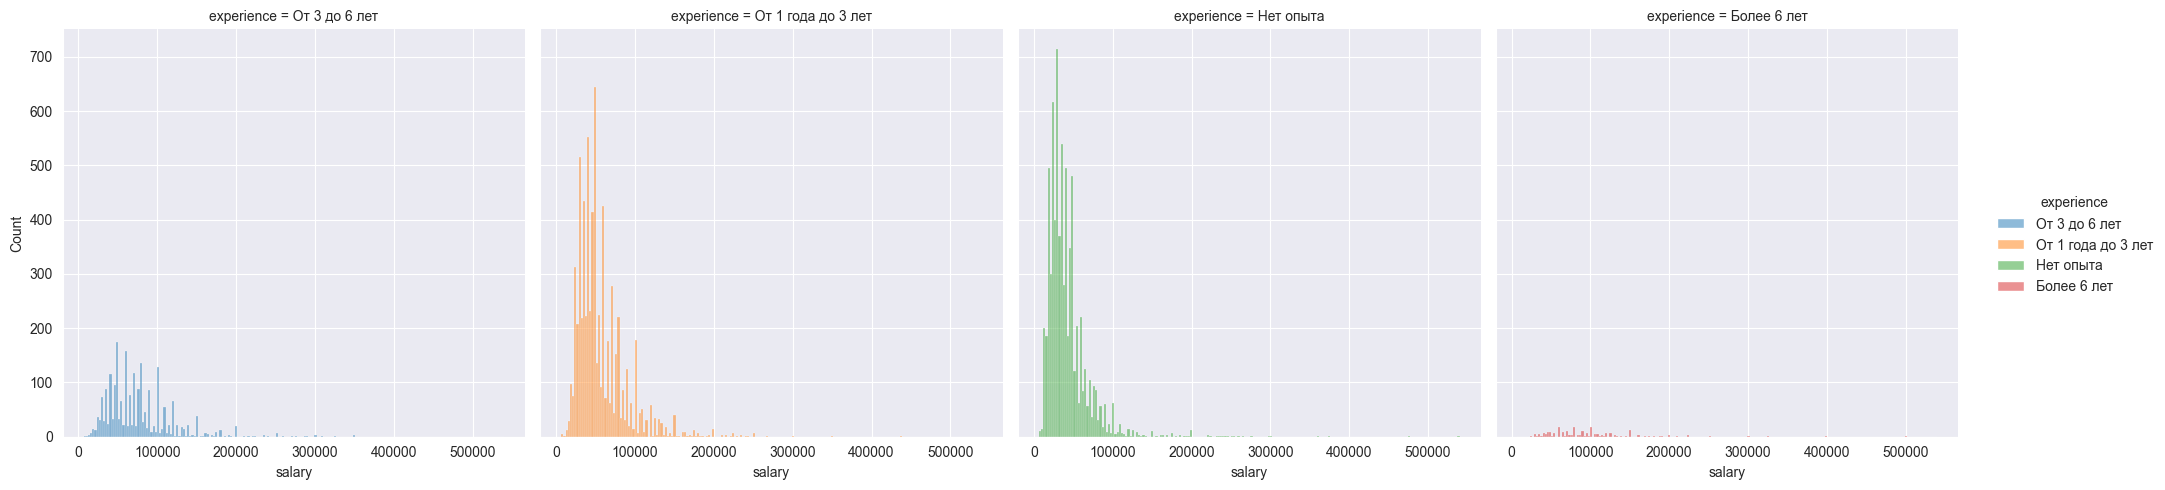

In [14]:
# your code here
sns.displot(data=df_train, x="salary", hue="experience", col='experience')

Вакансий с графиком занятости, отличной от полной, совсем не много. **Наверное стоит отдельно посмотреть, не отличается ли описание таких вакансий**.

<Axes: xlabel='schedule', ylabel='Count'>

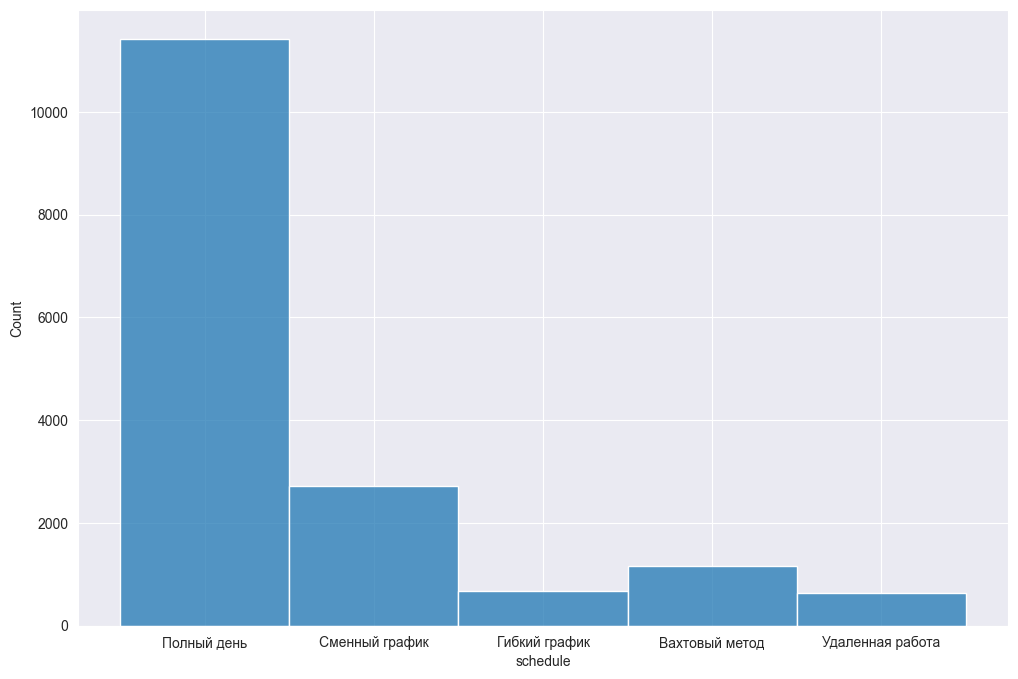

In [15]:
sns.histplot(df_train.schedule)

<Axes: xlabel='employment', ylabel='Count'>

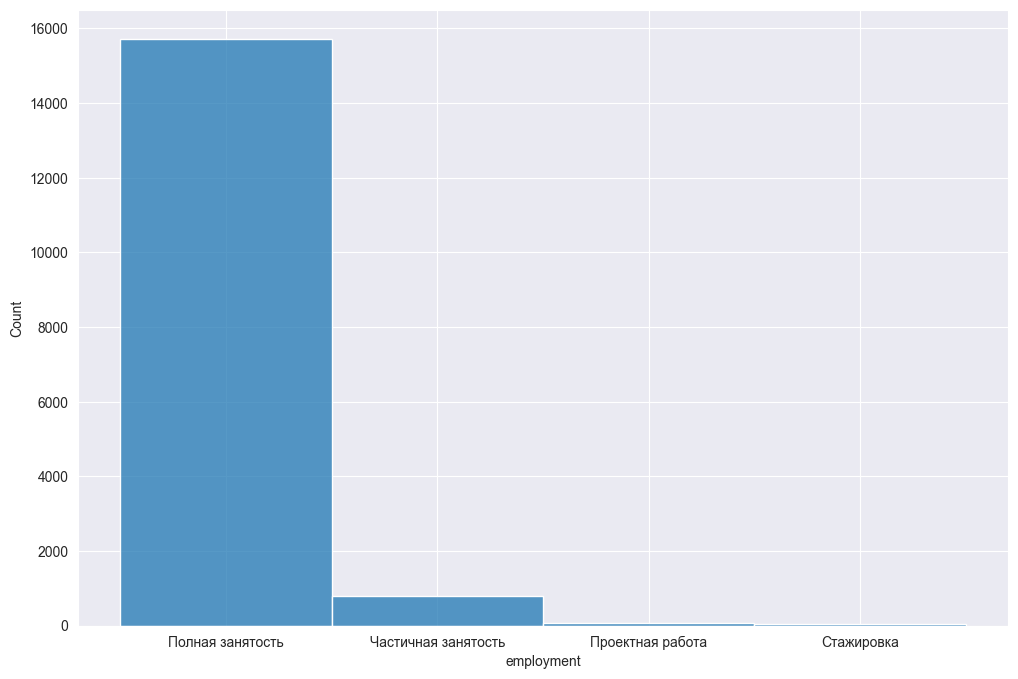

In [16]:
sns.histplot(df_train.employment)

In [81]:
df_train.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary', 'Опыт работы', 'Зарплата'],
      dtype='object')

In [17]:
df_train.isna().sum()

name           0
experience     0
schedule       0
employment     0
description    0
key_skills     0
salary         0
dtype: int64

In [18]:
import pandas as pd

df_fulltime = df_train[df_train['employment'] == 'Полная занятость'][['description', 'employment']].rename(columns={'description': 'description_1', 'employment': 'employment_1'}).reset_index(drop=True)
df_parttime = df_train[df_train['employment'] == 'Частичная занятость'][['description', 'employment']].rename(columns={'description': 'description_2', 'employment': 'employment_2'}).reset_index(drop=True)
df_project = df_train[df_train['employment'] == 'Проектная работа'][['description', 'employment']].rename(columns={'description': 'description_3', 'employment': 'employment_3'}).reset_index(drop=True)
df_internship = df_train[df_train['employment'] == 'Стажировка'][['description', 'employment']].rename(columns={'description': 'description_4', 'employment': 'employment_4'}).reset_index(drop=True)

result = pd.concat([df_fulltime, df_parttime, df_project, df_internship], axis=1)

result

,description_1,employment_1,description_2,employment_2,description_3,employment_3,description_4,employment_4
0,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ тент, ГАЗЕЛЬ цельнометаллическая, ГАЗ фургон) Обязанности: развоз товара по точкам в черте г.Владимира и области по графику, доставка товара в Москву, Иваново, Рязань, экспедирование, приемка-передача товара в точках, разгрузка товара в точках, материальная ответственность за транспортное средство, груз, товаросопроводительные документы, содержание подотчетного транспортного средства в технически исправном рабочем состоянии, мелкий текущий ремонт и техобслуживание Требования: наличие водительского удостоверения категории В и/или С, спокойствие, выносливость, достаточная подготовка, вежливость, опыт текущего ремонта и техобслуживания отечественных транспортных средств Условия: выплата заработка 2 раза в месяц отпуск два раза в год (осень-весна) по 14 календарных дней официальное трудоустройство и соцпакет",Полная занятость,"Работа на территории работодателя: р-н Кущевский, с. Полтавченское, ул Трудовая, д. 3, корп. б Обязанности: Оказывает доврачебную медицинскую помощь, осуществляет забор биологических материалов для лабораторных исследований. Осуществляет уход за больными в медицинской организации и на дому. Осуществляет стерилизацию медицинских инструментов, перевязочных средств и предметов ухода за больными. Ассистирует при проведении врачом лечебно-диагностических манипуляций и малых операций в амбулаторных и стационарных условиях. Проводит подготовку пациентов к различного рода исследованиям, процедурам, операциям, к амбулаторному приему врача. Обеспечивает выполнение врачебных назначений. Осуществляет учет, хранение, использование лекарственных средств и этилового спирта. Ведет персональный учет, информационную (компьютерную) базу данных состояния здоровья обслуживаемого населения. Руководит деятельностью младшего медицинского персонала. Ведет медицинскую документацию. Проводит санитарно-просветительную работу среди больных и их родственников по укреплению здоровья и профилактике заболеваний, пропаганде здорового образа жизни. Осуществляет сбор и утилизацию медицинских отходов. Осуществляет мероприятия по соблюдению санитарно-гигиенического режима, правил асептики и антисептики, условий стерилизации инструментов и материалов, предупреждению постинъекционных осложнений, гепатита, ВИЧ-инфекции. Требования: Профильное образование + ""Сестринское дело в педиатрии"" Условия: С неполным рабочим днем 0,5 ставки Социальный пакет",Частичная занятость,"Работа на территории работодателя: г Геленджик, с Криница, б-р Приморский, д. 2, корп. Я Обязанности: Выполняет профилактические, лечебные, санитарно-гигиенические мероприятия, назначенные врачом-диетологом ЛПУ. Осуществляет контроль хранения запаса продуктов питания, качества пищевых продуктов при их поступлении на склад и пищеблок. Осуществляет контроль за работой пищеблока. Ежедневно подготавливает под контролем диетолога и при участии заведующего производством меню-раскладку (меню-требование) в соответствии с картотекой блюд (наименование блюд, их количество, номера диет, количество продуктов на все блюда, общее количество продуктов). Осуществляет контроль за правильностью закладки продуктов в котел и бракераж готовой пищи (снятие пробы), за выполнением технологических методов приготовления блюд для различных диет, за правильностью отпуска блюд с пищеблока в отделение в соответствии с раздаточной ведомостью, за санитарным состоянием раздаточных и буфетных отделений, инвентаря, посуды, а также за выполнением правил личной гигиены работниками раздаточных. Внедряет принципы рационального и лечебного питания с учетом норм физиологических потребностей, биологических свойств пищевых продуктов в диетотерапии, заболеваний, сохранения пищевой ценности продуктов питания при хранении и кулинарной обработке. Проводит учебные занятия со средним медицинским персоналом и работниками кухни по организации лечебного питания в ЛПУ. Ведет меди

Посмотрим, как часто различные требуемые навыки встречаются в поле `key_skills`. Логично предположить, что некоторые из них оказывают значимое влияние на предлагаемую зарплату. **Попробуйте проверить эту гипотезу**

In [19]:
from ast import literal_eval
from collections import OrderedDict

In [20]:
skills_count = dict()

for skill_list in df_train.key_skills:
    list_of_skills = literal_eval(skill_list)
    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
        else:
            skills_count[skill] += 1

skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)}
skills_count

{'Работа в команде': 2768,
 'Пользователь ПК': 2634,
 'Грамотная речь': 2221,
 'Умение работать в команде': 1150,
 'Активные продажи': 1066,
 'Деловое общение': 851,
 'Навыки продаж': 700,
 'Телефонные переговоры': 649,
 'Ведение переговоров': 630,
 'Организаторские навыки': 588,
 'Деловая переписка': 522,
 'Клиентоориентированность': 514,
 'Обучение и развитие': 494,
 'Поиск и привлечение клиентов': 479,
 'Грамотность': 461,
 'Работа с большим объемом информации': 420,
 'Прямые продажи': 402,
 'Заключение договоров': 357,
 'Холодные продажи': 352,
 'Ориентация на результат': 349,
 'AutoCAD': 344,
 'Управление персоналом': 342,
 'Консультирование': 340,
 '1С: Предприятие 8': 323,
 'Обучение персонала': 322,
 'Работа с людьми': 303,
 'Водительское удостоверение категории B': 289,
 'Навыки межличностного общения': 283,
 'Деловая коммуникация': 282,
 'Работа с кассой': 278,
 'Знание устройства автомобиля': 274,
 'Медицинская документация': 265,
 'Умение работать в коллективе': 263,
 'Англ

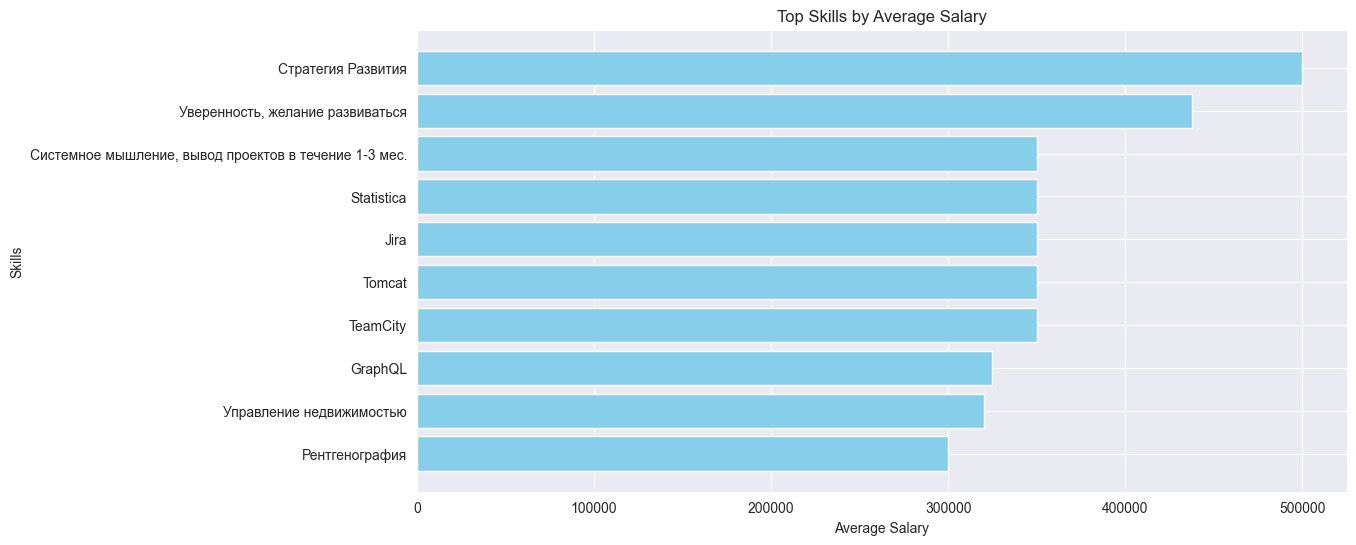

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

skills_count = dict()
skills_salary = dict()

for index, row in df_train.iterrows():
    list_of_skills = literal_eval(row['key_skills'])
    salary = row['salary']

    for skill in list_of_skills:
        if skill not in skills_count:
            skills_count[skill] = 1
            skills_salary[skill] = salary
        else:
            skills_count[skill] += 1
            skills_salary[skill] += salary

average_salary_by_skill = {skill: skills_salary[skill] / skills_count[skill] for skill in skills_count}

sorted_skills_by_salary = dict(sorted(average_salary_by_skill.items(), key=lambda item: item[1], reverse=True))

skills = list(sorted_skills_by_salary.keys())
avg_salary = list(sorted_skills_by_salary.values())

plt.figure(figsize=(12, 6))
plt.barh(skills[:10], avg_salary[:10], color='skyblue')
plt.xlabel('Average Salary')
plt.ylabel('Skills')
plt.title('Top Skills by Average Salary')
plt.gca().invert_yaxis()
plt.show()
# Возможно это одна/две вакансии, с высокой зп и скилом "Стратегия развития"

**Визуализацию данных из тестового датасета мы предлагаем вам сделать самостоятельно**. Вполне может оказаться так, что они сильно отличаются от трейна.

In [22]:
# your code here
df_test.name.value_counts()

name
Менеджер по продажам                                                70
Продавец-консультант                                                65
Кладовщик                                                           51
Менеджер по работе с клиентами                                      36
Медицинская сестра                                                  34
                                                                    ..
Disposal (диспозл)-менеджер по привлечению объектов недвижимости     1
Товаровед-Продавец                                                   1
Слесарь-ремонтник (5 разряд)                                         1
Повар (Камчатский край, Артель)                                      1
Торговый представитель (Колпино, Тосно, Кировск)                     1
Name: count, Length: 3716, dtype: int64

<Axes: xlabel='experience', ylabel='Count'>

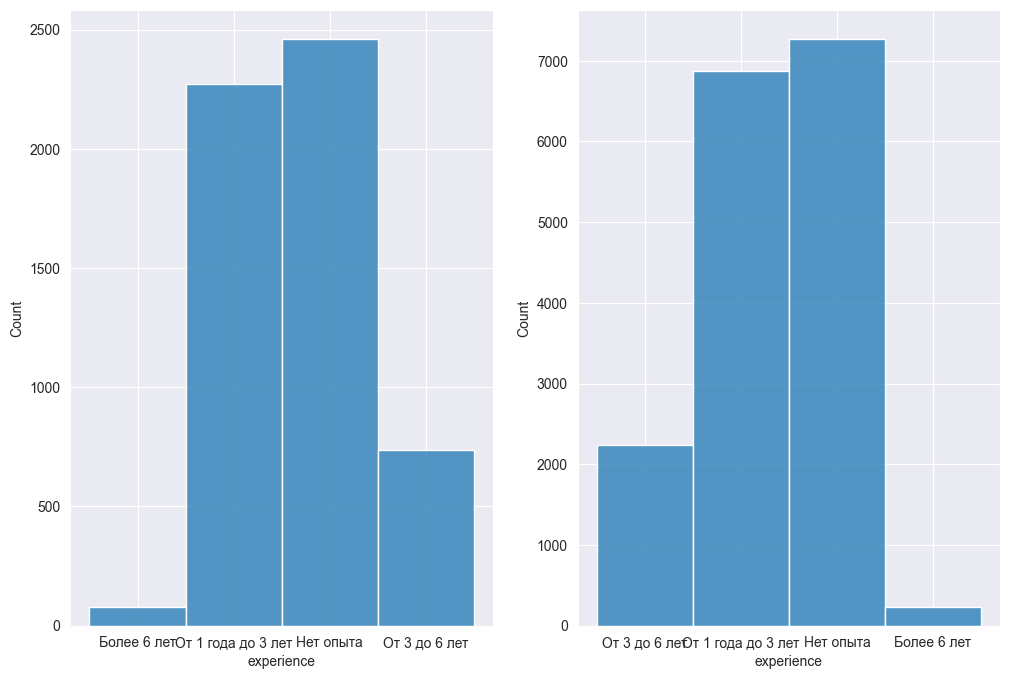

In [23]:
plt.subplot(1, 2, 1)
sns.histplot(df_test.experience)
plt.subplot(1, 2, 2)
sns.histplot(df_train.experience)

<Axes: xlabel='employment', ylabel='Count'>

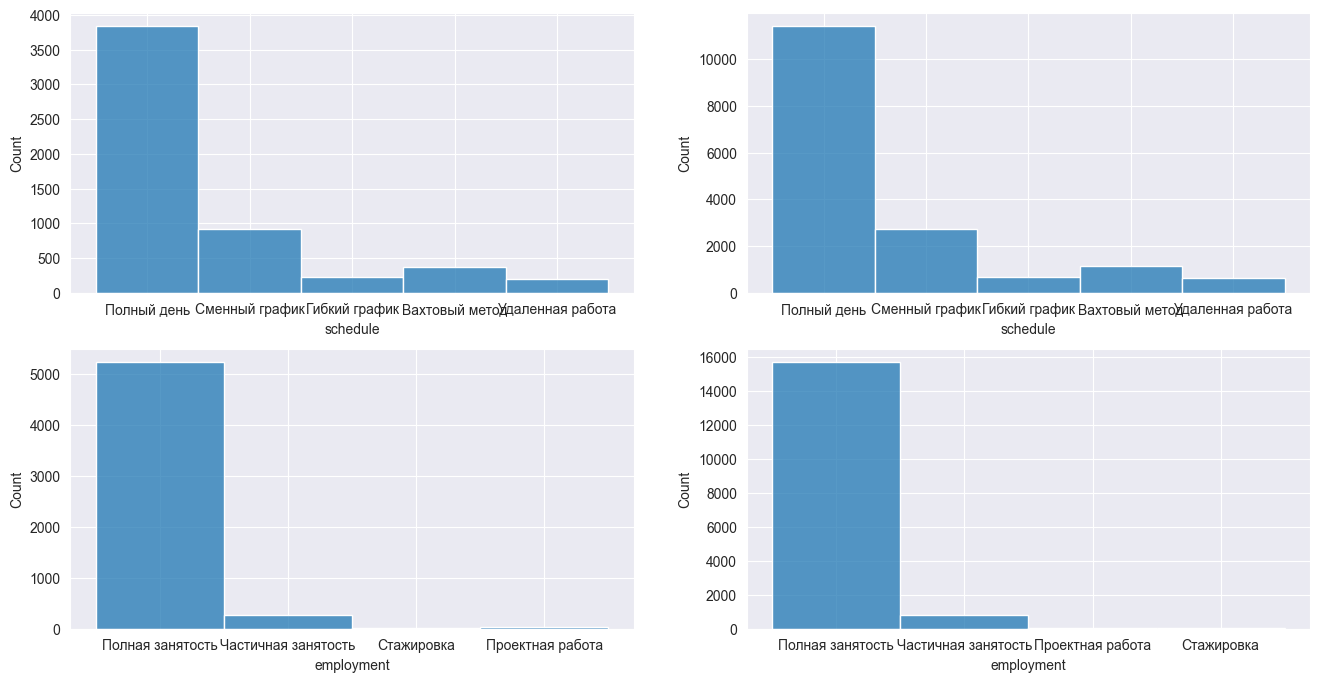

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
sns.histplot(df_test.schedule)
plt.subplot(2, 2, 2)
sns.histplot(df_train.schedule)
plt.subplot(2, 2, 3)
sns.histplot(df_test.employment)
plt.subplot(2, 2, 4)
sns.histplot(df_train.employment)

Постройте облако слов в описаниях вакансий

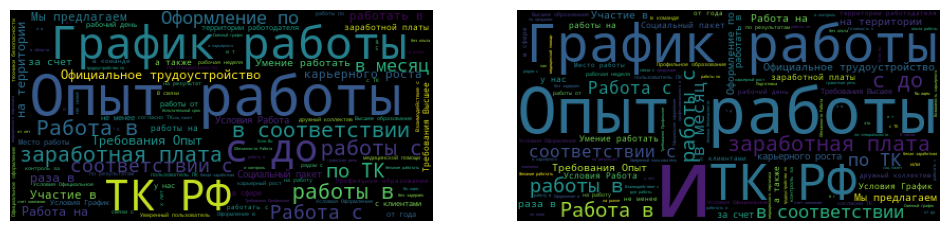

In [25]:
from wordcloud import WordCloud
merged_text = ' '.join(df_train['description'].tolist())

wc = WordCloud().generate(merged_text)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(wc)
merged_text = ' '.join(df_test['description'].tolist())

wc = WordCloud().generate(merged_text)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(wc)

# Preprocessing

В бейзлайне используем только описание и название вакансии. **Попробуйте в своих моделях учесть и другие признаки**.

In [26]:
df_train_new = pd.DataFrame()
df_train_new['text'] = df_train.name + ' ' + df_train.description
df_train_new

,text
0,"Водитель-экспедитор Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ тент, ГАЗЕЛЬ цельнометаллическая, ГАЗ фургон) Обязанности: развоз товара по точкам в черте г.Владимира и области по графику, доставка товара в Москву, Иваново, Рязань, экспедирование, приемка-передача товара в точках, разгрузка товара в точках, материальная ответственность за транспортное средство, груз, товаросопроводительные документы, содержание подотчетного транспортного средства в технически исправном рабочем состоянии, мелкий текущий ремонт и техобслуживание Требования: наличие водительского удостоверения категории В и/или С, спокойствие, выносливость, достаточная подготовка, вежливость, опыт текущего ремонта и техобслуживания отечественных транспортных средств Условия: выплата заработка 2 раза в месяц отпуск два раза в год (осень-весна) по 14 календарных дней официальное трудоустройство и соцпакет"
1,"Кладовщик-комплектовщик/оператор 1С Обязанности: Списывание материалов в производство Прием ТМЦ, разгрузка товара Оприходование материалов и готовой продукции на склад Размещение материалов на складе Ведение документооборота Контроль складских остатков Составление заявок на пополнения складских остатков Ведение номенклатуры в базе 1С Обеспечение сохранности ТМЦ Поддержание порядка на складе. Требования: Знание программы 1с Внимательность, аккуратность Умение работать в команде Знание номенклатуры металлопроката будет преимуществом Условия: отличный коллектив, людей, которые ответственно относятся к своей работе, отвечают каждый за свою работу и результат, у нас точно не получится просто ""отбывать номер"", мы платим зарплату по верхней планке за работу есть опытный кладовщик, который всё покажет, инструкции по выполнению всех операций в 1С быстро растущая торгово-производственная компания, лидер рынка производства дизайнерского света и инсталляций производим светильники высокого качества по индивидуальным заказам. испытательный срок 1 мес оформление по ТК РФ график 5/2 с 9.00 до 18.00, у нас даже время обеда оплачивается все необходимые бытовые условия - раздевалка, место для обедов, холодильник, микроволновые печи, спецодежда и СИЗ Пишите в Whats App или звоните!"
2,"Продавец магазина ""Магнит"" (Кировский р-он, В. Уса) В крупнейшую Федеральную сеть магазинов ""Магнит"" требуется продавец магазина в связи с расширением. Обязанности: - обслуживание покупателей на кассе;- консультирование покупателей при выборе товара;- участие в выкладке товаров, актуализации ценников;- участие в инвентаризациях Требования: - Исполнительность,- Умение работать в команде,- Высокая работоспособность,- Ответственность.- Приветствуется стремление к обучению, развитию и освоению новых технологий. Условия: - График 2/2, 12 часовой рабочий день,- Официальная заработная плата,- Работа рядом с домом,- Корпоративные пенсионные программы,- Корпоративное обучение,- Конкурсы профессионального мастерства Благодарим Вас за интерес, проявленный к нашей Компании.Стандартный срок рассмотрения резюме -14 дней.Отсутствие ответа в течение двух недель означает, что, к сожалению, на сегодня у нас нет подходящих вакансий. При этом Ваше резюме будет сохранено в нашей базе данных и если подходящая вакансия появится в последующем, мы предложим ее Вам для рассмотрения.Если Ваш опыт работы и пожелания соответствуют требованиям и возможностям компании - мы свяжемся с Вами по указанным контактам в течении двух недель."
3,"Администратор магазина (ТЦ Spar) Крупная федеральная сеть магазинов мужской и женской одежды ZOLLA ищет целеустремленного, преданного своему делу профессионала - АДМИНИСТРАТОРА, который готов справиться с любой задачей, работая в динамичном бизнесе.Вас ждет сильная команда единомышленников и большие возможности! Мы предлагаем: работу в активно развивающейся российской компании с официальным оформлением и социальными гарантиями; конкурентоспособную заработную плату, самое главное – точно и в срок!; работу в комфортном графике: 5/2 вых ПТ и СБ; дисконтную карту, позволяющую приобр

In [27]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()

# функция для очистки описаний
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # избавляемся от ссылок
    text = re.sub('[^а-яёА-ЯЁ]', ' ', text) # оставляем только кириллицу
    text = word_tokenize(text.lower()) # приводим к нижнему регистру и токенизируем по словам
    # приводим токены к нормальной форме, удаляем стоп-слова и короткие токены
    text = [morph.normal_forms(token)[0] for token in text
            if token not in stop_words and len(token) > 2]
    text = " ".join(text) # возвращаем строку
    return text

In [28]:
%time df_train_new['cleaned'] = df_train_new.text.apply(clean_text)
df_train_new

CPU times: total: 1min 45s
Wall time: 2min 51s


,text,cleaned
0,"Водитель-экспедитор Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ тент, ГАЗЕЛЬ цельнометаллическая, ГАЗ фургон) Обязанности: развоз товара по точкам в черте г.Владимира и области по графику, доставка товара в Москву, Иваново, Рязань, экспедирование, приемка-передача товара в точках, разгрузка товара в точках, материальная ответственность за транспортное средство, груз, товаросопроводительные документы, содержание подотчетного транспортного средства в технически исправном рабочем состоянии, мелкий текущий ремонт и техобслуживание Требования: наличие водительского удостоверения категории В и/или С, спокойствие, выносливость, достаточная подготовка, вежливость, опыт текущего ремонта и техобслуживания отечественных транспортных средств Условия: выплата заработка 2 раза в месяц отпуск два раза в год (осень-весна) по 14 календарных дней официальное трудоустройство и соцпакет",водитель экспедитор водитель экспедитор категория газель тент газель цельнометаллический газ фургон обязанность развоз товар точка черта владимир область график доставка товар москва иваново рязань экспедирование приёмка передача товар точка разгрузка товар точка материальный ответственность транспортный средство груз товаросопроводительный документ содержание подотчётный транспортный средство технически исправный рабочий состояние мелкий текущий ремонт техобслуживание требование наличие водительский удостоверение категория спокойствие выносливость достаточный подготовка вежливость опыт текущий ремонт техобслуживание отечественный транспортный средство условие выплата заработок раз месяц отпуск раз год осень весна календарный день официальный трудоустройство соцпакет
1,"Кладовщик-комплектовщик/оператор 1С Обязанности: Списывание материалов в производство Прием ТМЦ, разгрузка товара Оприходование материалов и готовой продукции на склад Размещение материалов на складе Ведение документооборота Контроль складских остатков Составление заявок на пополнения складских остатков Ведение номенклатуры в базе 1С Обеспечение сохранности ТМЦ Поддержание порядка на складе. Требования: Знание программы 1с Внимательность, аккуратность Умение работать в команде Знание номенклатуры металлопроката будет преимуществом Условия: отличный коллектив, людей, которые ответственно относятся к своей работе, отвечают каждый за свою работу и результат, у нас точно не получится просто ""отбывать номер"", мы платим зарплату по верхней планке за работу есть опытный кладовщик, который всё покажет, инструкции по выполнению всех операций в 1С быстро растущая торгово-производственная компания, лидер рынка производства дизайнерского света и инсталляций производим светильники высокого качества по индивидуальным заказам. испытательный срок 1 мес оформление по ТК РФ график 5/2 с 9.00 до 18.00, у нас даже время обеда оплачивается все необходимые бытовые условия - раздевалка, место для обедов, холодильник, микроволновые печи, спецодежда и СИЗ Пишите в Whats App или звоните!",кладовщик комплектовщик оператор обязанность списывание материал производство приём тмц разгрузка товар оприходование материал готовый продукция склад размещение материал склад ведение документооборот контроль складской остаток составление заявка пополнение складской остаток ведение номенклатура база обеспечение сохранность тмц поддержание порядок склад требование знание программа внимательность аккуратность умение работать команда знание номенклатура металлопрокат преимущество условие отличный коллектив человек который ответственно относиться свой работа отвечать каждый работа результат точно получиться просто отбывать номер платить зарплата верхний планка работа опытный кладовщик который всё показать инструкция выполнение операция быстро расти торговый производственный компания лидер рынок производство дизайнерский свет инсталляция производить светильник высокий качество индивидуальный заказ испытательный срок мес оформление график время обед оплачиваться необходимый бытовой условие раздевалка место обед холодильник

In [29]:
df_test_new = pd.DataFrame()
df_test_new['text'] = df_test.name + ' ' + df_test.description
%time df_test_new['cleaned'] = df_test_new['text'].apply(clean_text)

CPU times: total: 31.9 s
Wall time: 58.9 s


In [31]:
df_test_new

,text,cleaned
id,,
0,"Главный бухгалтер Обязанности:Осуществление организации бухгалтерского учета.Обеспечение рациональной организации бухгалтерского учета и отчетности на предприятии, отвечает за формирование и своевременное представление полной и достоверной отчетности в государственные органы.Контроль за полнотой отражения организацией хозяйственных операций на всех участках бухгалтерского и налогового учета.Составление и сдача ежемесячной и годовой налоговой отчетности, представление интересов предприятия в налоговых органах и казначействе, в Пенсионном фонде, в ФСС РФ, в банке, получение документов от вышеперечисленных организаций.Требования:Высшее профессиональное (экономическое) образование.Опыт работы не менее 10 лет.Знание программ 1С 7, 1С 8, ""Веснин"", СБИС, систем налогообложения ОСН, УСН.Руководство большим коллективом.Условия:Рабочий день с 09.45 - 18.00 часовСуббота, воскресенье - выходной.",главный бухгалтер обязанность осуществление организация бухгалтерский учёт обеспечение рациональный организация бухгалтерский учёт отчётность предприятие отвечать формирование своевременный представление полный достоверный отчётность государственный орган контроль полнота отражение организация хозяйственный операция участок бухгалтерский налоговый учёт составление сдача ежемесячный годовой налоговый отчётность представление интерес предприятие налоговый орган казначейство пенсионный фонд фсс банк получение документ вышеперечисленный организация требование высокий профессиональный экономический образование опыт работа менее год знание программа веснин сбис система налогообложение осн усн руководство больший коллектив условие рабочий день часовсуббота воскресение выходной
1,"Ассистент врача-стоматолога Обязанности: Ассистировать врачу стоматологу, подготовка необходимого инструментария; Подготовка рабочего места к приему пациента Контроль за чистотой и порядком в стоматологическом кабинете, проведение дезинфекции, предварительной чистки и стерилизации необходимых инструментов Ведение документации (журналов) Снимки (прицельной) Требования: Средне специальное медицинское образование ""Сестринское дело"" Наличие действующего сертификата и медицинской книжки Опыт работы в данной должности приветствуется Условия: График работы сменный Комфортные условия, дружный коллектив Оформление по ТК РФ",ассистент врач стоматолог обязанность ассистировать врач стоматолог подготовка необходимый инструментарий подготовка рабочий место приём пациент контроль чистота порядок стоматологический кабинет проведение дезинфекция предварительный чистка стерилизация необходимый инструмент ведение документация журнал снимок прицельный требование средне специальный медицинский образование сестринский дело наличие действовать сертификат медицинский книжка опыт работа дать должность приветствоваться условие график работа сменный комфортный условие дружный коллектив оформление
2,"Менеджер по продажам Если ты: хочешь построить карьеру в банковском секторе; ориентирован на высокие результаты в продажах; готов стать лидером и развиваться профессионально и личностно; мечтаешь работать в дружной команде профессионалов. Начни карьеру в крупнейшем банке России и СНГ! Как менеджер по продажам, ты будешь: активно продавать услуги банка; консультировать клиентов по всем продуктам и услугам банка, включая ипотеку; оформлять банковские продукты и услуги; помогать клиентам в оформлении необходимых документов; совершать транзакционные операции в рамках оформления продаж и постпродажного сопровождения клиентов; вести базы клиентов. Ты подходишь нам, если ты: специалист со средним профессиональным/неполным высшим/высшим образованием; имеешь опыт работы в сфере продаж, обслуживания и консультирования клиентов от 6 месяцев; владеешь программами Microsoft Office, Internet Explorer, Outlook; проявляешь доброжелательность, готовность оказывать помощь окружающим; способен справляться со сложными ситуациями и выдерживать высокий темп работы. Мы предлагаем: трудоустройство согласно

Рекомендуем **попробовать разные сочетания предобработки текста, векторизаторов и моделей в дальнейшем**

In [ ]:
# your code here


# Tf-Idf

In [32]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso

In [43]:
tfidf = TfidfVectorizer()
X_df_train = tfidf.fit_transform(df_train_new.cleaned)
X_df_train

<16612x29476 sparse matrix of type '<class 'numpy.float64'>'
	with 1361457 stored elements in Compressed Sparse Row format>

In [48]:
pd.DataFrame(X_df_train.toarray(), columns=tfidf.get_feature_names_out())

,ааа,аазс,аакцент,абаз,абак,абакан,абаканвагонмаш,абакина,абас,абатский,...,яшкинский,яшма,яшьлек,ящи,ящик,ёлва,ёлка,ёмко,ёмкостный,ёмкость
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X_df_test = tfidf.transform(df_test_new.text)
X_df_test

<5543x29476 sparse matrix of type '<class 'numpy.float64'>'
	with 174892 stored elements in Compressed Sparse Row format>

**Попробуйте OHE, bag-of-words. Используйте разные n-граммы**

In [ ]:
# your code here


# Fit & Predict

Применяем Lasso-регрессию. **Наверняка стоит попробовать более сложные модели и потюнить гиперпараметры** ([хендбук](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov), [Хабр](https://habr.com/ru/companies/otus/articles/754402/))

In [46]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df_train, df_train.salary, test_size=0.2, random_state=42)

lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [47]:
r2_score(y_test, y_pred)
# your code here

0.33933710557765084

# Catboost
В этом блоке советуем **попытаться запустить catboost**. Для этого в конструкторе класса `CatBoostRegressor` ([документация](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)) нужно в параметре `text_features` перечислить текстовые фичи. И ждать магии

In [ ]:
# your code here


## Прочие рекомендации

* **не игонрируйте этап разведочного анализа данных: чем подробнее и глубже вы его сделаете, тем более последовательно вы будете двигаться к лучшему вашему решению**
* **вы можете попробовать какую-то другую токенизацию; возможно в бейзлайне мы не учли что-то важное**
* **разумно попробовать учесть те признаки, что мы проигнорировали в базовом решении (хотя бы банальный OHE-encoding)**


### Дальше в ходе студкемпа мы научимся:
* **пользоваться Word2Vec (обучать с нуля, что не очень используется; или же использовать предобученную и дообучать на текстах задачи)**
* **для перехода к числовым представлениям слов можно попробовать и другие модели: GloVe, fastText, Doc2Vec**
* **или даже расчехлить не слишком тяжеловесные трансформерные**

Улучшите качество модели на вашей валидационной выборке настолько, насколько выйдет

In [ ]:
# your code here


# Анализ результатов

Проведите аналитику результатов. Сравните модели и способы предобработки. Укажите, каким образом удалось добиться наилучшего качества. Перечислите достоинства и недостатки для прода простых (a la OHE) и сложных (catboost с подобранными гиперпараметрами) моделей. Если время на эксперименты всё, то напишите свои мысли, как можно было бы улучшить прогноз